# 1. Data Exploration
First, we explore the dataset and perform some descriptive analysis

## Import necessary packages

In [289]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats  

# % matplotlib inline

# feature engineering
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder as le

# model training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# classifiers
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.tree import DecisionTreeClassifier # decision tree
from sklearn.ensemble import RandomForestClassifier # random forest
from sklearn.ensemble import GradientBoostingClassifier # gradient boosting

## Read CSV File

In [290]:
df = pd.read_csv('data/loan.csv',low_memory=True)
df.head()

/Users/chihongtao/anaconda/envs/notebook/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,nan,nan,2500,2500,2500.000000,36 months,13.560000,84.920000,C,C1,...,nan,nan,Cash,N,NaN,NaN,NaN,nan,nan,nan
1,nan,nan,30000,30000,30000.000000,60 months,18.940000,777.230000,D,D2,...,nan,nan,Cash,N,NaN,NaN,NaN,nan,nan,nan
2,nan,nan,5000,5000,5000.000000,36 months,17.970000,180.690000,D,D1,...,nan,nan,Cash,N,NaN,NaN,NaN,nan,nan,nan
3,nan,nan,4000,4000,4000.000000,36 months,18.940000,146.510000,D,D2,...,nan,nan,Cash,N,NaN,NaN,NaN,nan,nan,nan
4,nan,nan,30000,30000,30000.000000,60 months,16.140000,731.780000,C,C4,...,nan,nan,Cash,N,NaN,NaN,NaN,nan,nan,nan


## Check column info and NULL values

In [291]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Data columns (total 145 columns):
 #   Column                                      Non-Null Count    Dtype  
---  ------                                      --------------    -----  
 0   id                                          0 non-null        float64
 1   member_id                                   0 non-null        float64
 2   loan_amnt                                   2260668 non-null  int64  
 3   funded_amnt                                 2260668 non-null  int64  
 4   funded_amnt_inv                             2260668 non-null  float64
 5   term                                        2260668 non-null  object 
 6   int_rate                                    2260668 non-null  float64
 7   installment                                 2260668 non-null  float64
 8   grade                                       2260668 non-null  object 
 9   sub_grade                                   2260668 non-

## Distribution of loan amount, term, year

<ipython-input-292-2fb512dd40ec>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.axes()


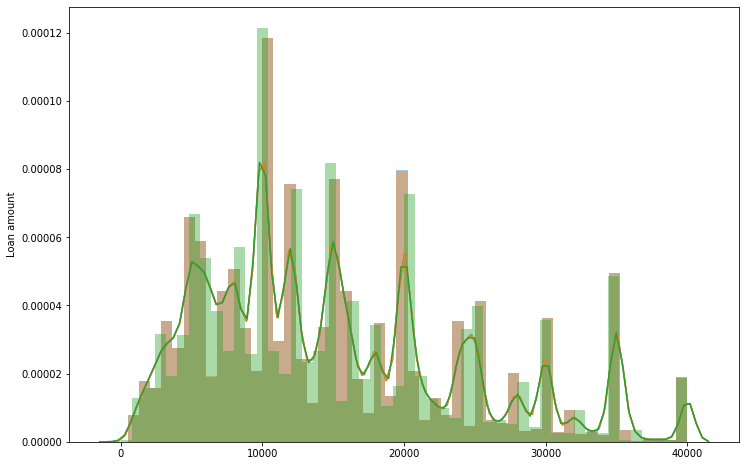

In [292]:
plt.figure(figsize=(12,8))
# Plot the distribution of loan amount applied by borrower
sns.distplot(df['loan_amnt'])
# Plot the distribution loan amount committeed
sns.distplot(df['funded_amnt'])
# Plot the distribution of loan amount committed by investors
sns.distplot(df['funded_amnt_inv'])
plt.ylabel('Loan amount')
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_label = x_axis.get_label()
x_label.set_visible(False)

 36 months   0.712070
 60 months   0.287930
Name: term, dtype: float64


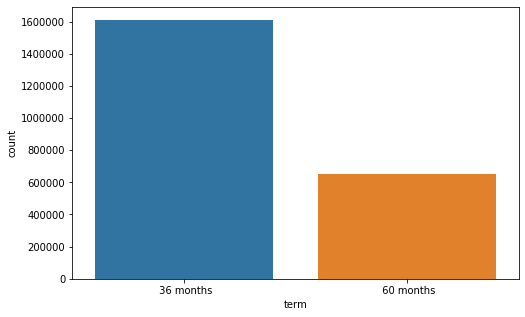

In [293]:
# Plot the term of the loans applied, in terms of percentage over all loans
print (df['term'].value_counts(normalize=True))
plt.figure(figsize=(8,5))
sns.countplot(df['term'])

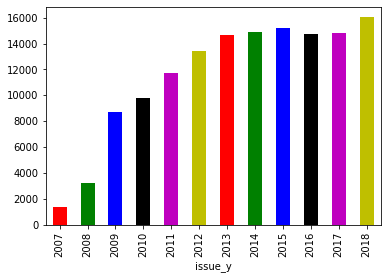

In [294]:
# Extract the year & month from issue_d and plot the average loan amount with respect to year
df['issue_y'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce').apply(lambda x: x.year)
df['issue_m'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce').apply(lambda x: x.month)
# Plot the funded loan amount by year
df.groupby('issue_y')['funded_amnt_inv'].mean().plot(kind='bar',color=['r', 'g', 'b', 'k', 'm', 'y'])
# sns.lineplot(df.groupby('issue_y')['funded_amnt_inv'].mean().index, df.groupby('issue_y')['funded_amnt_inv'].mean().values)

### Observation
* Loan amount applied follows a multi-nomial distribution, mostly falling within 10k - 20k range
* Loan amount applied, funded and funded_invested follows similar distributions, this means most loans applied by eligible borrowers are approved and funded by investor 
* _71%_ of the loans applied are for _36_ months, while _29%_ are for _60_ months.
* Average loan amount increases each year, with significant jump in _2009, peak around 2015-2018_. This is probably due to financial crisis in _2008_ , which resulted in low interest rate between _2009-2018_

In [295]:
# Inspect loan status
df['loan_status'].value_counts()

Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64

## Good Loan v.s. Bad Loan

* We categorise the loan as a bad loan if the loan status is any of these: _["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period", "Late (16-30 days)", "Late (31-120 days)"]_
* Also, there is a significant number of loans that are under the status of __"Current"__, which we cannot tell whether it is a good / bad loan. Hence, we need to __remove such loans__ before splitting into training/test dataset.
* With this categorisation, we can see _13%_ of the loans are bad loans. Hence, this is a very __imbalanced dataset__, with large number of negatives if we are predicting bad loans
* However, we have to keep in mind that some of the "good" loans are still in the process of getting paid, especially loans that are more recent in this time horizon. Hence, we observe higher percentage of good loans from _2016-2018_. But these may turn bad later.

[Text(0, 0.5, '(%)')]

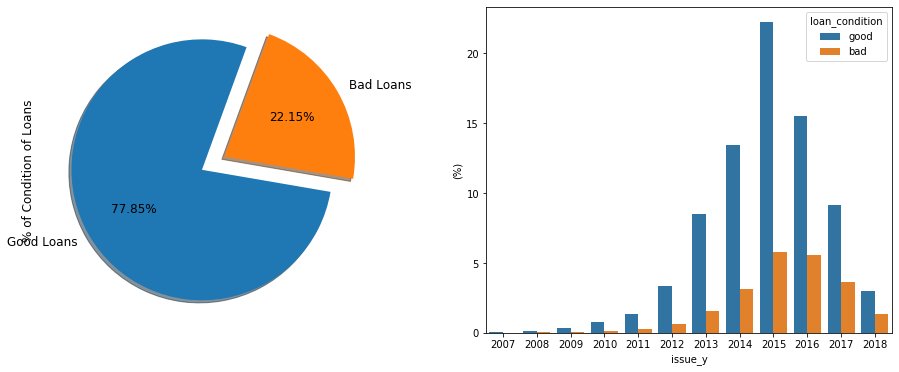

In [296]:
# Remove loans under "Current" status
df = df[df['loan_status']!='Current']

# We can categorise the loan as good / bad loan. 
# From the pie chart, 13% of the loans are bad loans
f, ax = plt.subplots(1,2, figsize=(16,6))
labels ="Good Loans", "Bad Loans"
bad_loan_statuses = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", \
                     "In Grace Period", "Late (16-30 days)", "Late (31-120 days)"]
df['loan_condition'] = df['loan_status'].apply(lambda x: 'bad' if x in bad_loan_statuses else 'good')
df['loan_condition'].value_counts().plot(kind='pie', explode=[0,0.2], autopct='%1.2f%%',\
                                         ax=ax[0], labels=labels, fontsize=12, startangle=70, shadow=True)
ax[0].set_ylabel('% of Condition of Loans', fontsize=12)

sns.barplot(x="issue_y", y="loan_amnt", hue="loan_condition", data=df,\
            estimator=lambda x: len(x) / len(df) * 100)
ax[1].set(ylabel="(%)")

## Plotting loans for each state

We can see that Lending clubs borrowers are most active in the few states where economy is doing well, e.g. California, Texas, New York, Florida, Illinois etc. While the states with lowest amount of loans are mostly in the Mid-West, such as North Dakota, Idaho, South Dakota etc. 

Text(0.5, 0, 'State')

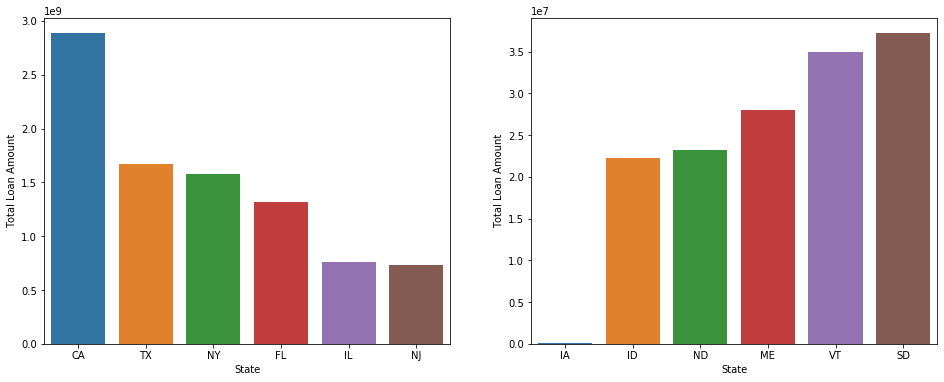

In [297]:
# Examine which state has the highest & lowest amount of loan in total
group_date = df.groupby(['addr_state'],as_index=False)['loan_amnt'].sum()
top_6_states = group_date.sort_values('loan_amnt',ascending=False).iloc[0:6]
btm_6_states = group_date.sort_values('loan_amnt').iloc[0:6]
fig, axs = plt.subplots(1,2, figsize=(16,6))
sns.barplot(x='addr_state', y='loan_amnt',data=top_6_states, ax=axs[0])
sns.barplot(x='addr_state', y='loan_amnt',data=btm_6_states, ax=axs[1])
axs[0].set_ylabel("Total Loan Amount")
axs[0].set_xlabel("State")
axs[1].set_ylabel("Total Loan Amount")
axs[1].set_xlabel("State")

### Observation
By plotting the loan condition splits for the top 6 & bottomr 6 states, we can see that states differ in the percentage of bad loans. 
* For the top 6 states in terms of loan amount, most of them have close to the overall average (~13%) of bad loans. 
* While for the bottom 6 states, the generally have less than the average % of bad loans. This could be due to these states being more financially conservative. 
* This means that state has a bearing on the percentage of good v.s. bad loans somehow

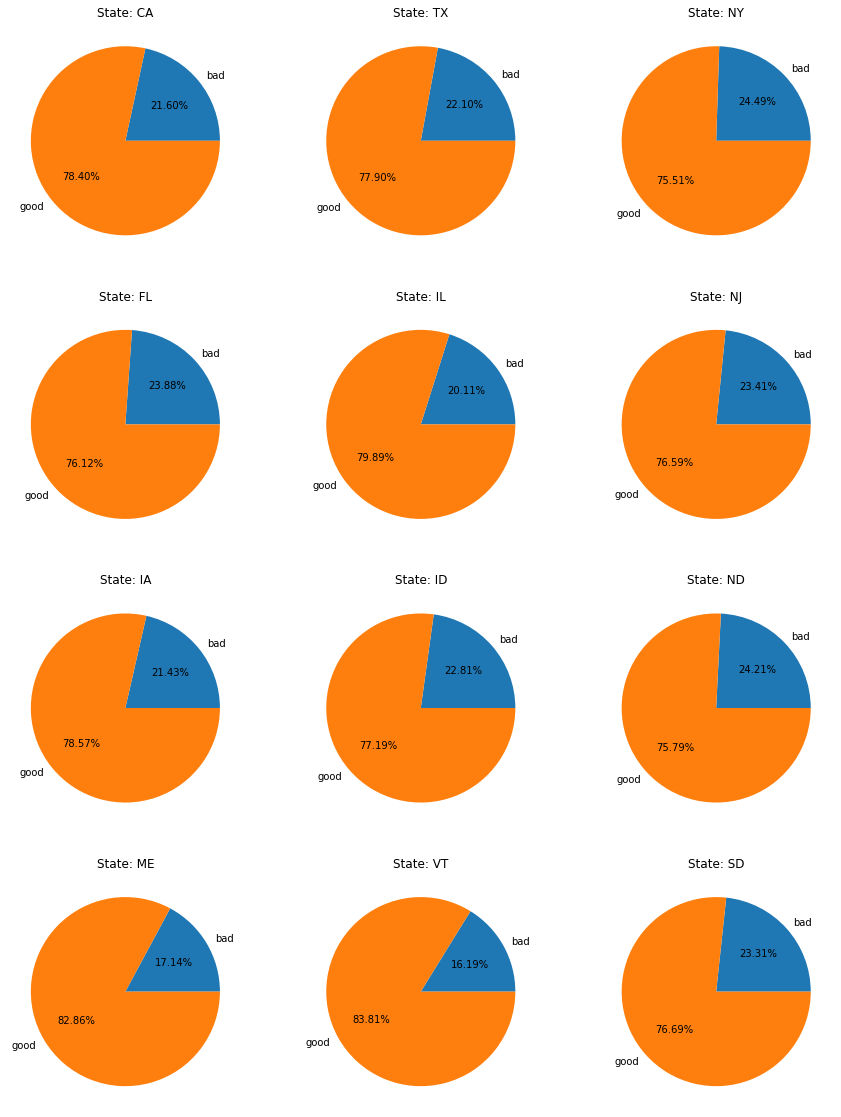

In [298]:
top_6_ls = list(top_6_states['addr_state'])
btm_6_ls = list(btm_6_states['addr_state'])
state_loan_condition = df.groupby('addr_state')['loan_condition'].value_counts(normalize=True).\
              unstack().reset_index().rename_axis(None, axis=1).set_index('addr_state')
plot_df = pd.concat([state_loan_condition.loc[top_6_ls], state_loan_condition.loc[btm_6_ls]])
# plot_df = state_loan_condition[~state_loan_condition.index.isin(['IA'])]
# print (plot_df.count())
# plot the pie good & bad loan percentage for the top 6 & bottom 6 states
fig = plt.figure(figsize=(15,20))
# print (state_loan_condition.count())
for i, (name, row) in enumerate(plot_df.iterrows()):
    ax = plt.subplot(4,3, i+1)
    ax.set_title("State: %s"%row.name)
    ax.set_aspect('equal')
    ax.pie(row, labels=row.index, autopct='%1.2f%%')

## Loan metrics by region
Hence, we decided to break down the country into four regions based on geography and plot some of the descriptive metrics for each region.

Text(0.5, 0, 'Year')

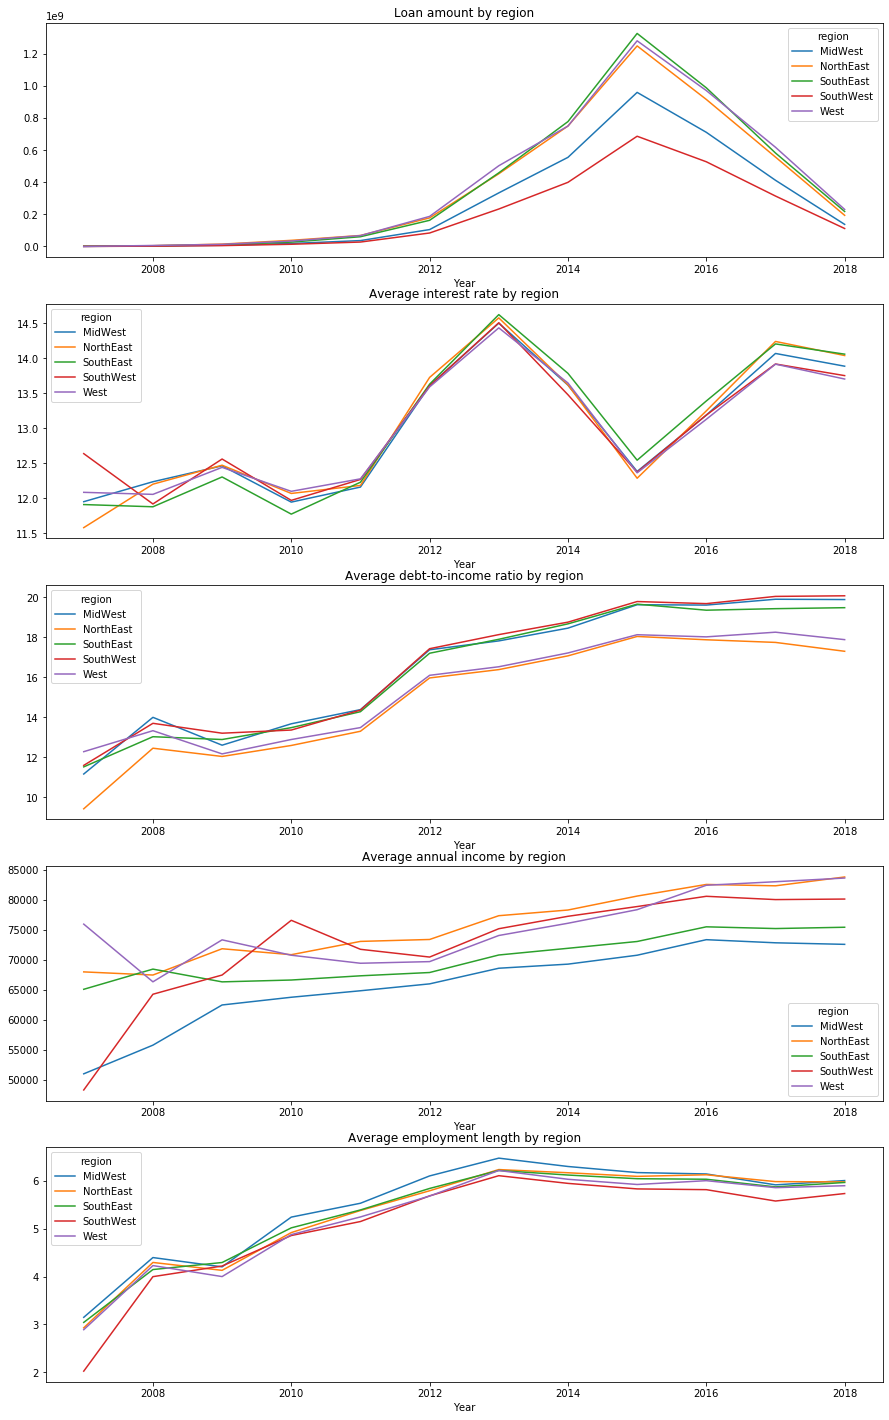

In [299]:
west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

df['region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'

df['region'] = df['addr_state'].apply(finding_regions)
    
df['emp_length_int'] = np.nan

def update_emp_length_int(emp_length):
    emp_length_int = None
    if emp_length == '10+ years':
        emp_length_int = 10
    elif emp_length == '9 years':
        emp_length_int = 9
    elif emp_length == '8 years':
        emp_length_int = 8
    elif emp_length == '7 years':
        emp_length_int = 7
    elif emp_length == '6 years':
        emp_length_int = 6
    elif emp_length == '5 years': 
        emp_length_int = 5
    elif emp_length == '4 years':
        emp_length_int = 4
    elif emp_length == '3 years':
        emp_length_int = 3
    elif emp_length == '2 years': 
        emp_length_int = 2
    elif emp_length == '1 year':
        emp_length_int = 1
    elif emp_length == '< 1 year':
        emp_length_int = 0.5
    elif emp_length == 'n/a':
        emp_length_int = 0    
    return emp_length_int

df['emp_length_int'] = df['emp_length'].apply(update_emp_length_int)

# plt.style.use('dark_background')
f, ax = plt.subplots(5,1, figsize=(15,25))

grouped_df = df.groupby(['issue_y','region'])

loan_by_region = grouped_df.loan_amnt.sum()
# loan_by_region_date.head()
loan_by_region.unstack().plot(ax=ax[0], stacked=False)
ax[0].set_title('Loan amount by region')
ax[0].set_xlabel('Year')

int_rate_by_region = grouped_df.int_rate.mean()
int_rate_by_region.unstack().plot(ax=ax[1])
ax[1].set_title('Average interest rate by region')
ax[1].set_xlabel('Year')

dti_by_region = grouped_df.dti.mean()
dti_by_region.unstack().plot(ax=ax[2])
ax[2].set_title('Average debt-to-income ratio by region')
ax[2].set_xlabel('Year')

income_by_region = grouped_df.annual_inc.mean()
income_by_region.unstack().plot(ax=ax[3])
ax[3].set_title('Average annual income by region')
ax[3].set_xlabel('Year')

emp_length_by_region = grouped_df.emp_length_int.mean()
emp_length_by_region.unstack().plot(ax=ax[4])
ax[4].set_title('Average employment length by region')
ax[4].set_xlabel('Year')

### Observation
* SouthEast, West, NorthEast have the highest total loans amounts for most of the years, while SouthWest has the lowest 
* This also corresponds to the average interest rate per year, where SouthEast & NorthEast are the highest in most years. This means loans in SouthEast & NorthEast tend to give higher returns 
* Despite the low total loan amounts, SouthWest has the highest debt to income ratio. While NorthEast & West have rather low debt-to-income ratio
* NorthEast & West have the highest average annual income, which might explain their low debt-to-income ratio
* MidWest has the highest average employment length, but annual income are the lowest 

## Loan condition by region
Here, we plot the loan condition - good / bad, for each region, similar to how we plotted by states

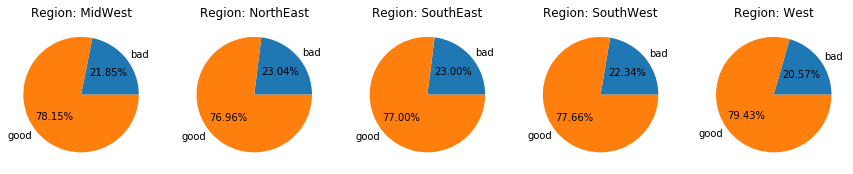

In [300]:
reg_loan_condition = df.groupby('region')['loan_condition'].value_counts(normalize=True).\
              unstack().reset_index().rename_axis(None, axis=1).set_index('region')
# plot the pie good & bad loan percentage for each region
fig = plt.figure(figsize=(15,20))
# print (state_loan_condition.count())
for i, (name, row) in enumerate(reg_loan_condition.iterrows()):
    ax = plt.subplot(1,5, i+1)
    ax.set_title("Region: %s"%row.name)
    ax.set_aspect('equal')
    ax.pie(row, labels=row.index, autopct='%1.2f%%')

Let's have a closer look at breakdown of __bad loans__ for each region. We can see that for each state, majority of the bad loans are charged off. 

<Figure size 1080x2160 with 0 Axes>

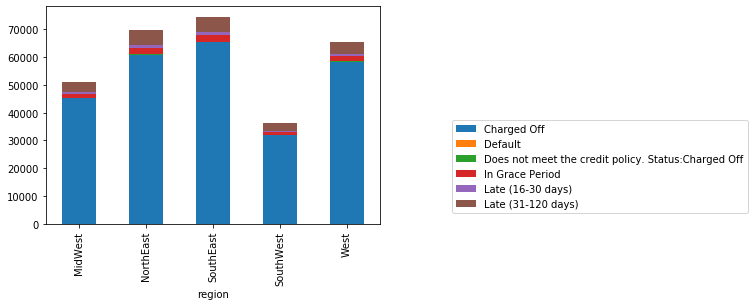

In [301]:
bad_loan_df = df[df['loan_condition']=='bad']
# print (pd.crosstab(bad_loan_df['region'], bad_loan_df['loan_status']))
fig = plt.figure(figsize=(15,30))
bad_loan_df.groupby(['region','loan_status'])['loan_amnt'].count().unstack().plot(kind='bar',stacked=True).legend(bbox_to_anchor=(1.2, 0.5))

# 2. Data Pre-processing

Next, we will perform data pre-processing to prepare the data to be used for prediction

## Split the data into Train, Test set
First, we split the dataframe into x - variables, y - labels (whether the loan is a good / bad loan). Here, we classify these loan status as bad loans, for which either the borrower is not able to pay back, or is late in payment. For this, we will use the newly created column: loan_condition, which will be the y label in our dataset. Later during training, we also need to __drop loan_status column__ from the x variables, because of its correlation with the label column.

In [302]:
y = df['loan_condition']
x = df.drop(columns=['loan_condition'])
# print (df.shape)
# print (x.shape)
# print (y.shape)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=0)
# print (x_train.shape)
# print (x_test.shape)
# print (y_train.shape)
# print (y_test.shape)
df_train = x_train.merge(y_train, left_index=True, right_index=True)
df_test = x_test.merge(y_test, left_index=True, right_index=True)
print (df_train.info(verbose=True, null_counts=True))
print (df_test.info(verbose=True, null_counts=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1005729 entries, 1832470 to 868271
Data columns (total 151 columns):
 #   Column                                      Non-Null Count    Dtype         
---  ------                                      --------------    -----         
 0   id                                          0 non-null        float64       
 1   member_id                                   0 non-null        float64       
 2   loan_amnt                                   1005729 non-null  int64         
 3   funded_amnt                                 1005729 non-null  int64         
 4   funded_amnt_inv                             1005729 non-null  float64       
 5   term                                        1005729 non-null  object        
 6   int_rate                                    1005729 non-null  float64       
 7   installment                                 1005729 non-null  float64       
 8   grade                                       1005729 non-

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335244 entries, 733217 to 698290
Data columns (total 151 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   id                                          0 non-null       float64       
 1   member_id                                   0 non-null       float64       
 2   loan_amnt                                   335244 non-null  int64         
 3   funded_amnt                                 335244 non-null  int64         
 4   funded_amnt_inv                             335244 non-null  float64       
 5   term                                        335244 non-null  object        
 6   int_rate                                    335244 non-null  float64       
 7   installment                                 335244 non-null  float64       
 8   grade                                       335244 non-null  object 

## Pre-processing of the training / test data
From above information, we can see for quite a few columns, there are significant number of rows with null values. This is common for both the training and test dataset. Next, we will attempt to reduce some of the less useful columns, and also remove some outliers records.

First, we try to reduce the feature set by checking how many columns has less than 30% of non-null values, and only keeping those. 

(1340973, 151)
(58,)


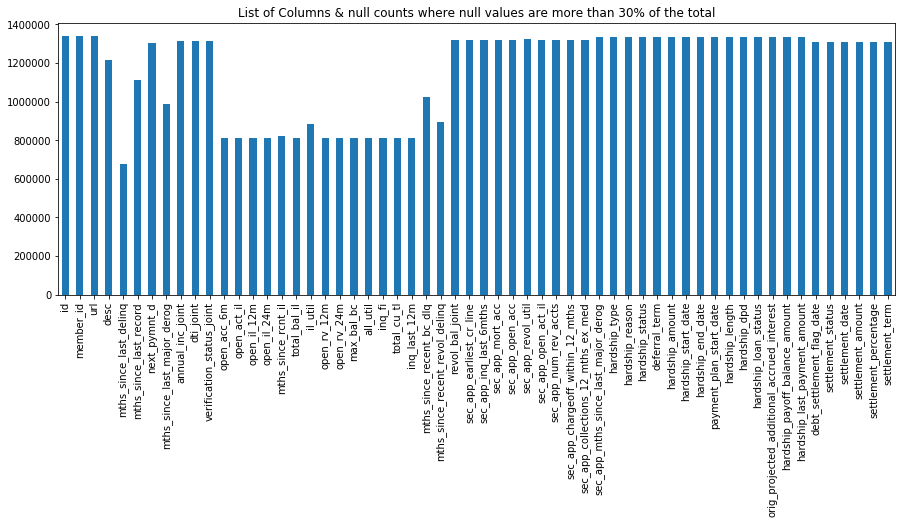

In [303]:
print (df.shape)
null_col = df.isnull().sum()
null_col = null_col[null_col.values >(0.3*len(df))]
print (null_col.shape)
plt.figure(figsize=(15,5))
null_col.plot(kind='bar')
plt.title('List of Columns & null counts where null values are more than 30% of the total')
plt.show()

From above plot, we can see that out of the 151 columns from the original dataset, 58 columns have more than 30% of the rows with nul values. We will hence drop these 58 columns in both the training and test dataset, since too many null values will not help much in our training and prediction.

In [304]:
df_train.drop(columns=list(null_col.index), inplace=True)
print (df_train.shape)
df_test.drop(columns=list(null_col.index), inplace=True)
print (df_test.shape)

(1005729, 93)
(335244, 93)


Similarly, we check if there are any rows that have less than 30% of non-null values populated. We will go ahead and remove those rows

In [305]:
# Drop rows with too many null values, for training data
df_transposed = df_train.transpose()
null_rows = df_transposed.isnull().sum()
null_rows = null_rows[null_rows.values >(0.3*len(df_transposed))]
print (null_rows.shape)
df_train.drop(axis=0, labels=list(null_rows.index), inplace=True)
print (df_train.shape)

# Drop rows with too many null values, for test data
df_transposed = df_test.transpose()
null_rows = df_transposed.isnull().sum()
null_rows = null_rows[null_rows.values >(0.3*len(df_transposed))]
print (null_rows.shape)
df_test.drop(axis=0, labels=list(null_rows.index), inplace=True)
print (df_test.shape)

(37705,)
(968024, 93)
(12742,)
(322502, 93)


After dropping null columns & rows, we check for columns where there is only one unique values. Those are not very useful in prediction, and hence we will remove those as well. We will do this for both the training and test dataset

In [306]:
unique = df_train.nunique()
df_train.drop(axis=1, labels=list(unique[unique==1].index), inplace=True)
print (unique[unique==1])
print (df_train.shape)

unique = df_test.nunique()
df_test.drop(axis=1, labels=list(unique[unique==1].index), inplace=True)
print (unique[unique==1])
print (df_test.shape)

policy_code    1
dtype: int64
(968024, 92)
policy_code    1
dtype: int64
(322502, 92)


Next, we handle a few specific columns. We will do below for both the training & test dataset.
* For employment length column, we will fill the null values with 0.
* We will also drop the zip code column, as geographical information is already contained in state (addr_state) field.

In [348]:
# print (df_unique.emp_length.value_counts(dropna=False))
df_train.emp_length.fillna(0, inplace=True)
df_test.emp_length.fillna(0,inplace=True)
df_train.drop(columns='zip_code',inplace=True)
df_test.drop(columns='zip_code',inplace=True)
print (df_train.shape)
print (df_test.shape)

(900078, 84)
(299189, 84)


Next, we derive some useful columns based on domain understanding, which we believe can be useful for our training and prediction, including creating range variables for some of the most commonly used varables, such as loan_amnt, annual_inc, int_rate. We do this for both the training and test dataset. 

In [308]:
# Calculate the ratio of loan to annual income, as an indication of the risk for the borrower
df_train['loan_to_income_ratio'] = df_train['loan_amnt'] / df_train['annual_inc']
df_test['loan_to_income_ratio'] = df_test['loan_amnt'] / df_test['annual_inc']
# In the previous section on explorative data analysis, we also added columns like issue_y, issue_m, region
# pd.set_option('float_format', '{:f}'.format)
# df_unique.describe()

# Create bins for loan amount, annual income, interest rate
bins = [0, 5000, 10000, 15000, 20000, 25000,40000]
slot = ['0-5000', '5000-10000', '10000-15000', '15000-20000', '20000-25000','25000 and above']
df_train['loan_amnt_range'] = pd.cut(df_train['loan_amnt'], bins, labels=slot)
df_test['loan_amnt_range'] = pd.cut(df_test['loan_amnt'], bins, labels=slot)

bins = [-1, 25000, 50000, 75000, 100000,110000000]
slot = ['0-25000', '25000-50000', '50000-75000', '75000-100000', '100000 and above']
df_train['annual_inc_range'] = pd.cut(df_train['annual_inc'], bins, labels=slot)
df_test['annual_inc_range'] = pd.cut(df_test['annual_inc'], bins, labels=slot)

bins = [0, 7.5, 10, 12.5, 15,35]
slot = ['0-7.5', '7.5-10', '10-12.5', '12.5-15', '15 and above']
df_train['int_rate_range'] = pd.cut(df_train['int_rate'], bins, labels=slot)
df_test['int_rate_range'] = pd.cut(df_test['int_rate'], bins, labels=slot)

print (df_train.shape)
print (df_test.shape)

(968024, 95)
(322502, 95)


In [310]:
df_train.info(verbose=True, null_counts=True)
df_train.drop(columns='full_date',inplace=True)
df_test.drop(columns='full_date',inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 968024 entries, 1832470 to 868271
Data columns (total 95 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   loan_amnt                   968024 non-null  int64         
 1   funded_amnt                 968024 non-null  int64         
 2   funded_amnt_inv             968024 non-null  float64       
 3   term                        968024 non-null  object        
 4   int_rate                    968024 non-null  float64       
 5   installment                 968024 non-null  float64       
 6   grade                       968024 non-null  object        
 7   sub_grade                   968024 non-null  object        
 8   emp_title                   905986 non-null  object        
 9   emp_length                  910259 non-null  object        
 10  home_ownership              968024 non-null  object        
 11  annual_inc                  96802

## Univariate Analysis - continuous variable

Then, we will perform some __univariate analysis__ on both continuous and categorical variables, in order to remove outliers to further trim down on the number of rows. 

First, we examine of some of the key continuous variables, namely Loan Amount, Interest Rate, Annual Income

(962406, 94)
(320715, 94)


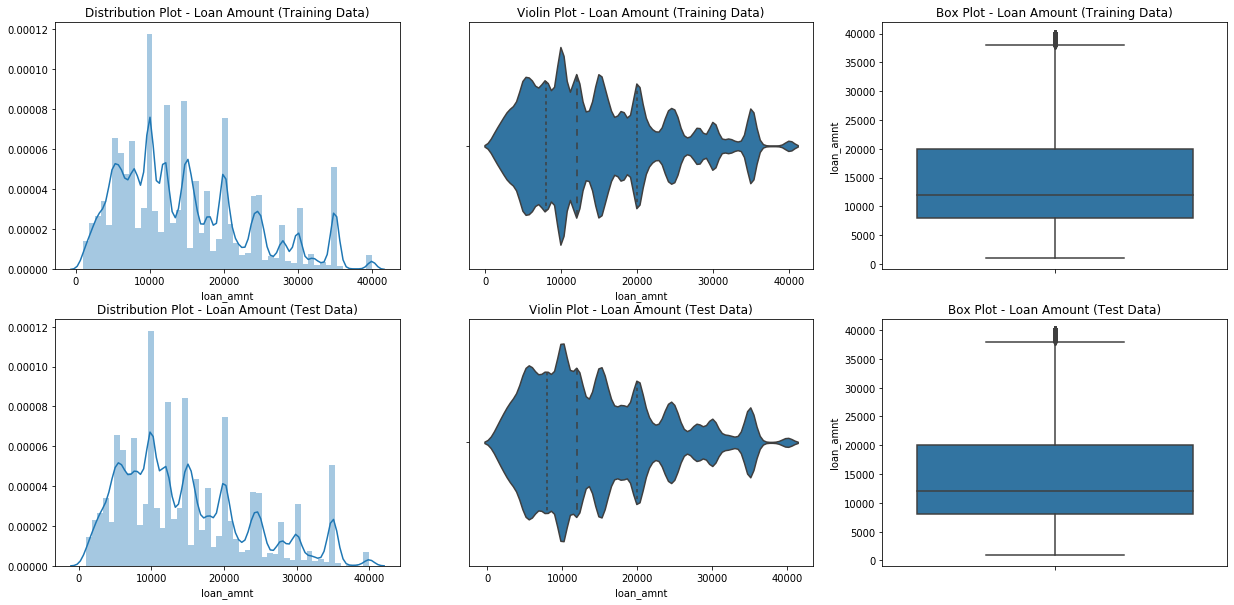

In [311]:
# Plotting for Loan Amount, in training dataset
fig, ax = plt.subplots(2,3,figsize=(21,10))
ax[0][0].set_title("Distribution Plot - Loan Amount (Training Data)")
sns.distplot(df_train['loan_amnt'],ax=ax[0][0])
ax[0][1].set_title("Violin Plot - Loan Amount (Training Data)")
sns.violinplot(data=df_train, x='loan_amnt',ax=ax[0][1], inner="quartile")
ax[0][2].set_title("Box Plot - Loan Amount (Training Data)")
sns.boxplot(data=df_train, x='loan_amnt',ax=ax[0][2],orient='v')

# Plottting for Loan Amount, in test dataset
ax[1][0].set_title("Distribution Plot - Loan Amount (Test Data)")
sns.distplot(df_test['loan_amnt'],ax=ax[1][0])
ax[1][1].set_title("Violin Plot - Loan Amount (Test Data)")
sns.violinplot(data=df_test, x='loan_amnt',ax=ax[1][1], inner="quartile")
ax[1][2].set_title("Box Plot - Loan Amount (Test Data)")
sns.boxplot(data=df_test, x='loan_amnt',ax=ax[1][2],orient='v')

# Extract outliers from the boxplot and remove the rows from training dataset
outlier_train_loan_amnt = boxplot_stats(df_train['loan_amnt']).pop(0)['fliers']
df_train = df_train[~df_train['loan_amnt'].isin(outlier_train_loan_amnt)]
print (df_train.shape)

# Extract outliers from the boxplot and remove the rows from training dataset
outlier_test_loan_amnt = boxplot_stats(df_test['loan_amnt']).pop(0)['fliers']
df_test = df_test[~df_test['loan_amnt'].isin(outlier_test_loan_amnt)]
print (df_test.shape)

(945743, 94)
(314256, 94)


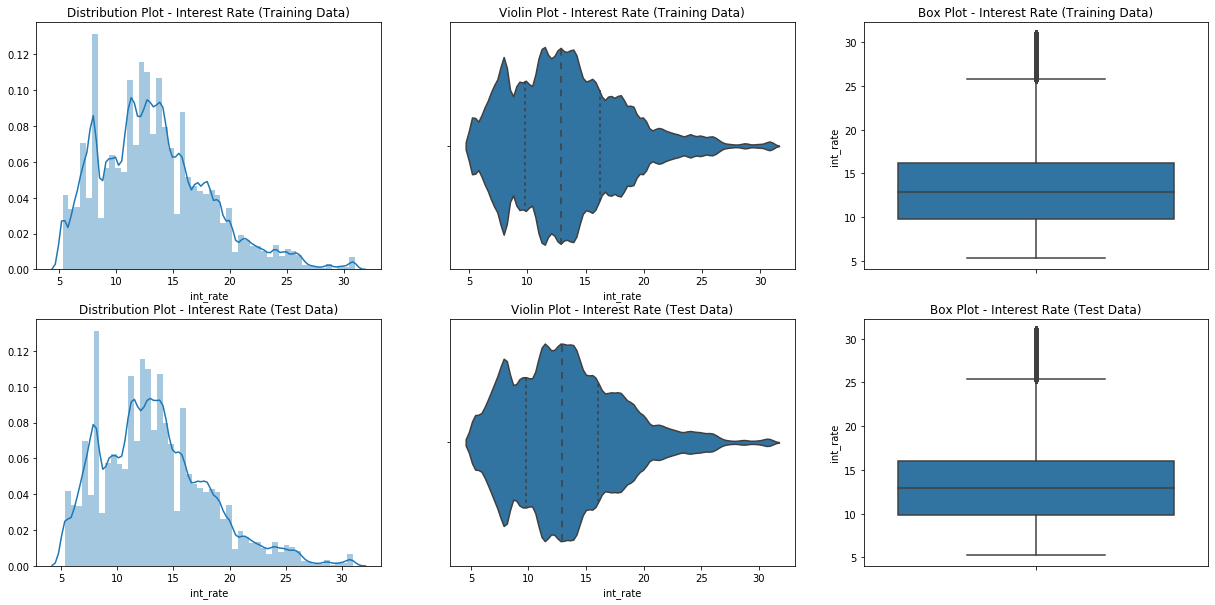

In [312]:
# Plotting for Interest rate, in training dataset
fig, ax = plt.subplots(2,3,figsize=(21,10))
ax[0][0].set_title("Distribution Plot - Interest Rate (Training Data)")
sns.distplot(df_train['int_rate'],ax=ax[0][0])
ax[0][1].set_title("Violin Plot - Interest Rate (Training Data)")
sns.violinplot(data=df_train, x='int_rate',ax=ax[0][1], inner="quartile")
ax[0][2].set_title("Box Plot - Interest Rate (Training Data)")
sns.boxplot(data=df_train, x='int_rate',ax=ax[0][2],orient='v')

# Plottting for Interest Rate, in test dataset
ax[1][0].set_title("Distribution Plot - Interest Rate (Test Data)")
sns.distplot(df_test['int_rate'],ax=ax[1][0])
ax[1][1].set_title("Violin Plot - Interest Rate (Test Data)")
sns.violinplot(data=df_test, x='int_rate',ax=ax[1][1], inner="quartile")
ax[1][2].set_title("Box Plot - Interest Rate (Test Data)")
sns.boxplot(data=df_test, x='int_rate',ax=ax[1][2],orient='v')

# Extract outliers from the boxplot and remove the rows from training dataset
outlier_train_int_rate = boxplot_stats(df_train['int_rate']).pop(0)['fliers']
df_train = df_train[~df_train['int_rate'].isin(outlier_train_int_rate)]
print (df_train.shape)

# Extract outliers from the boxplot and remove the rows from training dataset
outlier_test_int_rate = boxplot_stats(df_test['int_rate']).pop(0)['fliers']
df_test = df_test[~df_test['int_rate'].isin(outlier_test_int_rate)]
print (df_test.shape)

(900334, 94)
(299280, 94)


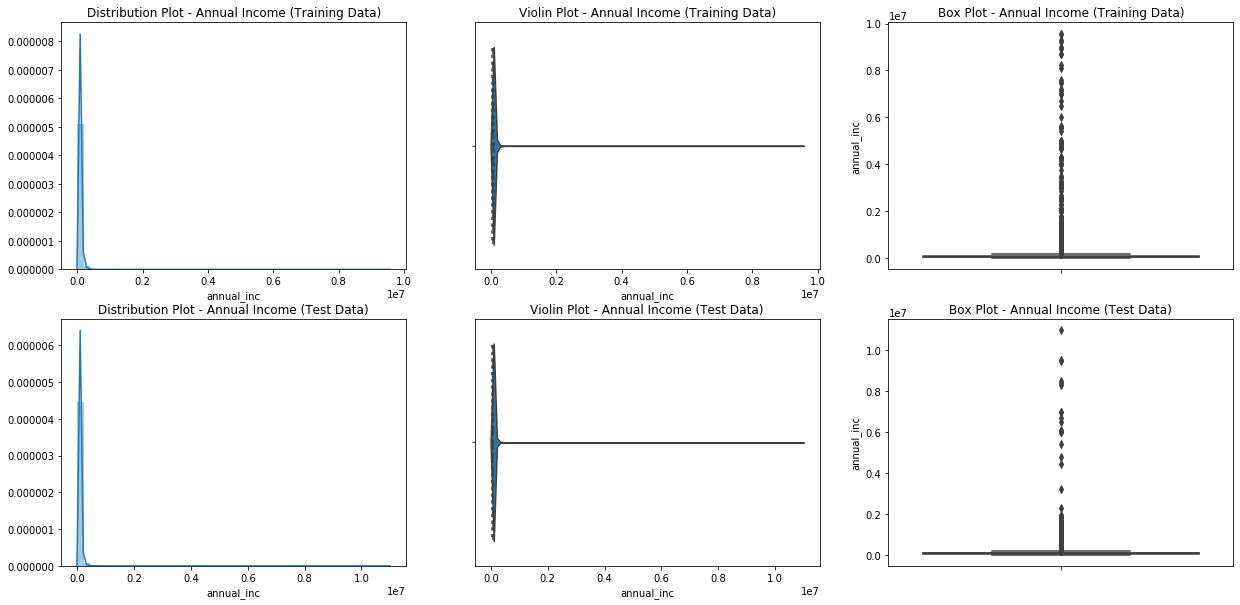

In [313]:
# Optional to run this cell twice, as there are some extreme outliers that need to be removed in the first pass
# Plotting for Annual income, in training dataset
fig, ax = plt.subplots(2,3,figsize=(21,10))
ax[0][0].set_title("Distribution Plot - Annual Income (Training Data)")
sns.distplot(df_train['annual_inc'],ax=ax[0][0])
ax[0][1].set_title("Violin Plot - Annual Income (Training Data)")
sns.violinplot(data=df_train, x='annual_inc',ax=ax[0][1], inner="quartile")
ax[0][2].set_title("Box Plot - Annual Income (Training Data)")
sns.boxplot(data=df_train, x='annual_inc',ax=ax[0][2],orient='v')

# Plottting for Annual Income, in test dataset
ax[1][0].set_title("Distribution Plot - Annual Income (Test Data)")
sns.distplot(df_test['annual_inc'],ax=ax[1][0])
ax[1][1].set_title("Violin Plot - Annual Income (Test Data)")
sns.violinplot(data=df_test, x='annual_inc',ax=ax[1][1], inner="quartile")
ax[1][2].set_title("Box Plot - Annual Income (Test Data)")
sns.boxplot(data=df_test, x='annual_inc',ax=ax[1][2],orient='v')

# Extract outliers from the boxplot and remove the rows from training dataset
outlier_train_annual_inc = boxplot_stats(df_train['annual_inc']).pop(0)['fliers']
df_train = df_train[~df_train['annual_inc'].isin(outlier_train_annual_inc)]
print (df_train.shape)

# Extract outliers from the boxplot and remove the rows from training dataset
outlier_test_annual_inc = boxplot_stats(df_test['annual_inc']).pop(0)['fliers']
df_test = df_test[~df_test['annual_inc'].isin(outlier_test_annual_inc)]
print (df_test.shape)

In [314]:
print (df_train.loan_amnt)
print (df_train.int_rate.describe())
print (df_train.annual_inc.describe())

1832470     9600
1253673    35000
2091381    16950
1955095    12000
1982916     4000
           ...  
951465      2800
648279      2800
1786043    16450
593487      7000
868271      3500
Name: loan_amnt, Length: 900334, dtype: int64
count   900334.000000
mean        13.171373
std          4.427616
min          5.310000
25%          9.920000
50%         12.790000
75%         15.990000
max         25.780000
Name: int_rate, dtype: float64
count   900334.000000
mean     68005.313967
std      30148.893039
min          0.000000
25%      45000.000000
50%      62500.000000
75%      85000.000000
max     156000.000000
Name: annual_inc, dtype: float64


### Observation (continuous variable)
* After removing the outliers, we can see that most of the loans have loan amount between 8000-20000 USD 
* Most of the loans have interest rate between 5-15% 
* Most of the borrowers have annual income between 45000 to 90000 USD



## Univariate Analysis - Categorical variables
Next we investigate on some of the key categorical variables, namely Loan status, Purpose, Home Ownership, and Term of the loan

Fully Paid           0.778878
Charged Off          0.195928
Late (31-120 days)   0.015973
In Grace Period      0.006470
Late (16-30 days)    0.002735
Default              0.000017
Name: loan_status, dtype: float64
Fully Paid           0.780423
Charged Off          0.194804
Late (31-120 days)   0.015701
In Grace Period      0.006459
Late (16-30 days)    0.002576
Default              0.000037
Name: loan_status, dtype: float64


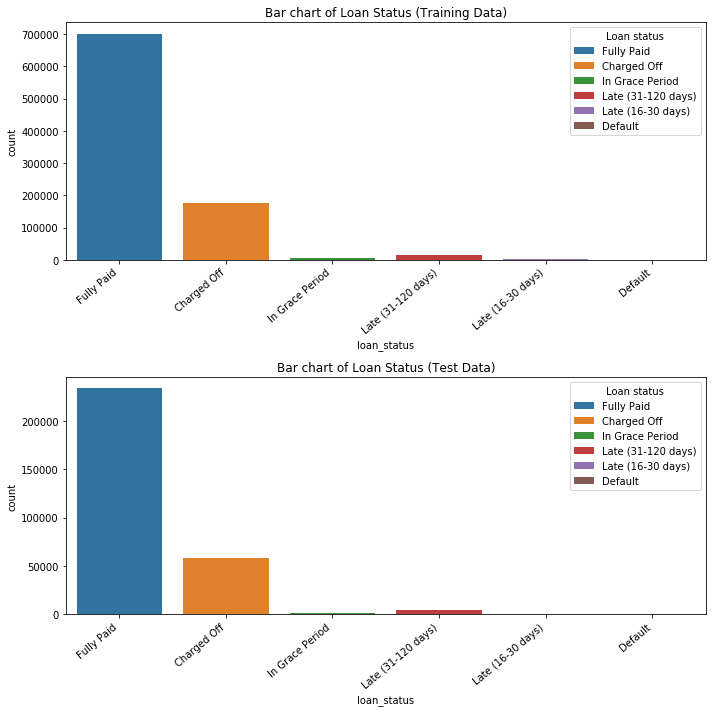

In [315]:
# Plot for Loan Status
print (df_train.loan_status.value_counts(normalize=True))
print (df_test.loan_status.value_counts(normalize=True))
f, ax = plt.subplots(2,1,figsize=(10,10))
labels=["Fully Paid", "Charged Off",  "In Grace Period", "Late (31-120 days)", "Late (16-30 days)", "Default"]

# Plot for Loan Status - training data
sns.countplot(data = df_train, x='loan_status', hue='loan_status', order = labels, hue_order=labels, dodge=False ,ax=ax[0])
h,l = ax[0].get_legend_handles_labels()
ax[0].legend(h,labels,title="Loan status", loc="upper right") 
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title("Bar chart of Loan Status (Training Data)")

# Plot for Loan Status - test data
sns.countplot(data = df_test, x='loan_status', hue='loan_status', order = labels, hue_order=labels, dodge=False ,ax=ax[1])
h,l = ax[1].get_legend_handles_labels()
ax[1].legend(h,labels,title="Loan status", loc="upper right") 
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
ax[1].set_title("Bar chart of Loan Status (Test Data)")

plt.tight_layout()
plt.show()

### Observation - Loan Status
* Without considering loans that are "Current", the dataset is still quite imbalanced. Majority of the loans are fully paid, and bad loans account for a relatively small percentage of the total loans (20%-30%)

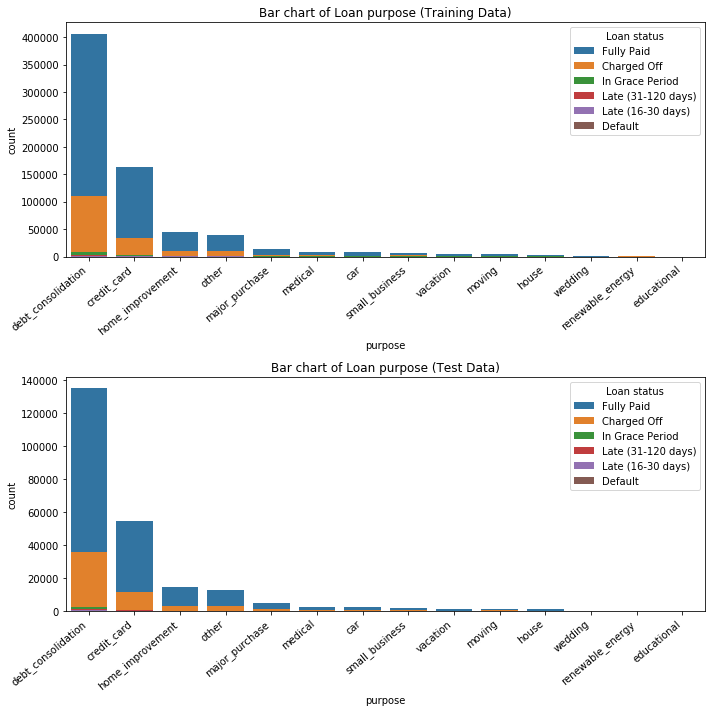

(900333, 94)
(299280, 94)


In [316]:
# Plot for Loan purpose
# print (df_train.purpose.value_counts(normalize=True))
# print (df_test.purpose.value_counts(normalize=True))
f, ax = plt.subplots(2,1,figsize=(10,10))
labels = list(df_train.purpose.value_counts().index)
labels_status=["Fully Paid", "Charged Off",  "In Grace Period", "Late (31-120 days)", "Late (16-30 days)", "Default"]

# Plot for Loan purpose - training data
# print (df_train.purpose.value_counts(normalize=True))
sns.countplot(data = df_train, x='purpose', hue='loan_status', order = labels, dodge=False ,ax=ax[0])
h,l = ax[0].get_legend_handles_labels()
ax[0].legend(h,labels_status,title="Loan status", loc="upper right") 
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title("Bar chart of Loan purpose (Training Data)")

# Plot for Loan Status - test data
# print (df_test.purpose.value_counts(normalize=True))
sns.countplot(data = df_test, x='purpose', hue='loan_status', order = labels, dodge=False ,ax=ax[1])
h,l = ax[1].get_legend_handles_labels()
ax[1].legend(h,labels_status,title="Loan status", loc="upper right") 
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
ax[1].set_title("Bar chart of Loan purpose (Test Data)")

plt.tight_layout()
plt.show()

# Remove loans that are for "educational" purpose as they are not very representative of the larger dataset
df_train = df_train[df_train['purpose']!='educational']
df_test = df_test[df_test['purpose']!='educational']
print (df_train.shape)
print (df_test.shape)

### Observation - Purpose
* Close to 60% of the loans are applied for debt consolidation purpose, i.e. to repay other debt.
* Some of the loan purposes account for a minimal percentage, e.g. educational. These can be removed. 

(900078, 94)
(299189, 94)


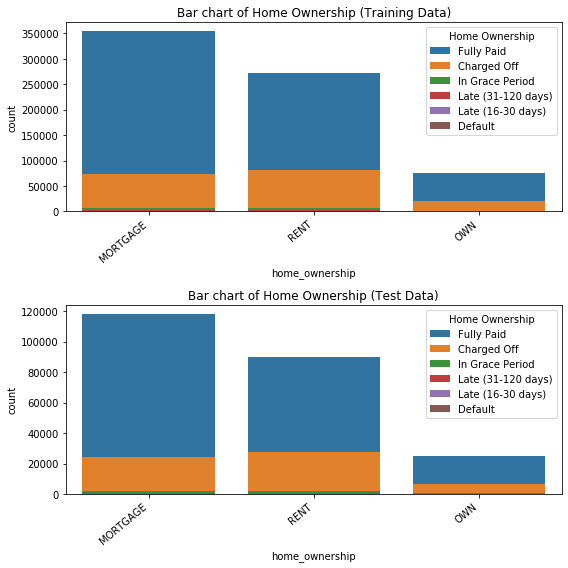

In [317]:
# Plot for Home ownership column
# print (df_train.home_ownership.value_counts(normalize=True))
# print (df_test.home_ownership.value_counts(normalize=True))
# Remove rows that are a very small proportion of the total loans
to_remove = ['ANY','NONE','OTHER']
df_train = df_train[~df_train.home_ownership.isin(to_remove)]
df_test = df_test[~df_test.home_ownership.isin(to_remove)]
print (df_train.shape)
print (df_test.shape)

f, ax = plt.subplots(2,1,figsize=(8,8))
labels = list(df_train.home_ownership.value_counts().index)
labels_status=["Fully Paid", "Charged Off",  "In Grace Period", "Late (31-120 days)", "Late (16-30 days)", "Default"]

# Plot for Loan purpose - training data
# print (df_train.purpose.value_counts(normalize=True))
sns.countplot(data = df_train, x='home_ownership', hue='loan_status', order = labels, dodge=False ,ax=ax[0])
h,l = ax[0].get_legend_handles_labels()
ax[0].legend(h,labels_status,title="Home Ownership", loc="upper right") 
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title("Bar chart of Home Ownership (Training Data)")

# Plot for Loan Status - test data
# print (df_test.purpose.value_counts(normalize=True))
sns.countplot(data = df_test, x='home_ownership', hue='loan_status', order = labels, dodge=False ,ax=ax[1])
h,l = ax[1].get_legend_handles_labels()
ax[1].legend(h,labels_status,title="Home Ownership", loc="upper right") 
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
ax[1].set_title("Bar chart of Home Ownership (Test Data)")

plt.tight_layout()
plt.show()

### Observation - Homeownership
* Majority of the loans are registered with these home ownership status: _['MORTGAGE','RENT','OWN']_. Hence we will remove rows with the rest of the statuses

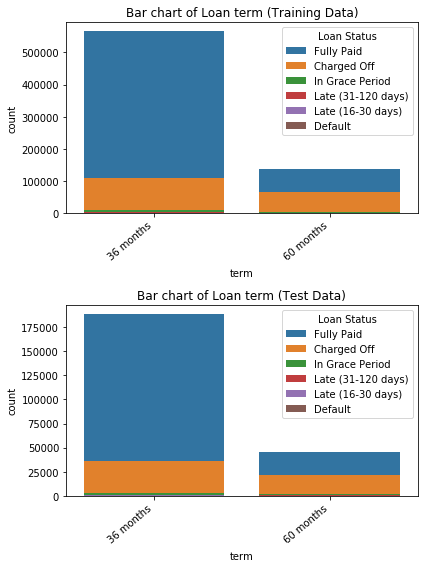

In [318]:
# Plot for Loan Term
f, ax = plt.subplots(2,1,figsize=(6,8))
labels = list(df_train.term.value_counts().index)
labels_status=["Fully Paid", "Charged Off",  "In Grace Period", "Late (31-120 days)", "Late (16-30 days)", "Default"]

# Plot for Loan Term - training data
sns.countplot(data = df_train, x='term', hue='loan_status', order = labels, dodge=False ,ax=ax[0])
h,l = ax[0].get_legend_handles_labels()
ax[0].legend(h,labels_status,title="Loan Status", loc="upper right") 
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title("Bar chart of Loan term (Training Data)")

# Plot for Loan Term - test data
sns.countplot(data = df_test, x='term', hue='loan_status', order = labels, dodge=False ,ax=ax[1])
h,l = ax[1].get_legend_handles_labels()
ax[1].legend(h,labels_status,title="Loan Status", loc="upper right") 
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
ax[1].set_title("Bar chart of Loan term (Test Data)")

plt.tight_layout()
plt.show()

### Observation - Term
* We can see that loans with a longer term (i.e. 60 months) are more likely to be bad loan

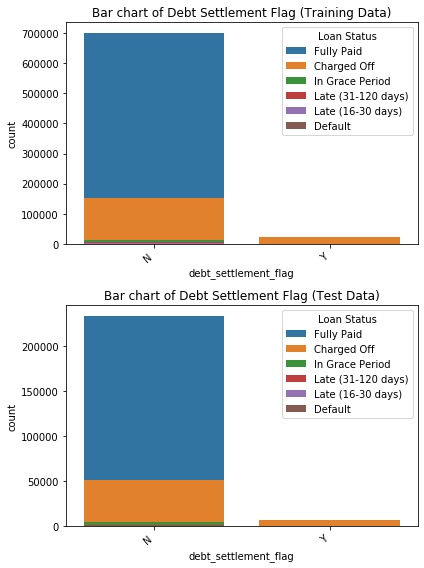

In [324]:
# Plot for Debt Settlement Flag, which indicates whether or not the borrower, who has charged off, is working with a debt-settlement company
f, ax = plt.subplots(2,1,figsize=(6,8))
labels = list(df_train.debt_settlement_flag.value_counts().index)
labels_status=["Fully Paid", "Charged Off",  "In Grace Period", "Late (31-120 days)", "Late (16-30 days)", "Default"]

# Plot for Debt Settlement Flag - training data
sns.countplot(data = df_train, x='debt_settlement_flag', hue='loan_status', order = labels, dodge=False ,ax=ax[0])
h,l = ax[0].get_legend_handles_labels()
ax[0].legend(h,labels_status,title="Loan Status", loc="upper right") 
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title("Bar chart of Debt Settlement Flag (Training Data)")

# Plot for Debt Settlement Flag - test data
sns.countplot(data = df_test, x='debt_settlement_flag', hue='loan_status', order = labels, dodge=False ,ax=ax[1])
h,l = ax[1].get_legend_handles_labels()
ax[1].legend(h,labels_status,title="Loan Status", loc="upper right") 
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
ax[1].set_title("Bar chart of Debt Settlement Flag (Test Data)")

plt.tight_layout()
plt.show()

### Observation - Debt Settlement Flag
* From a business perspective, the debt settlement flag only applies if a loan has already been charged off.
* Therefore, this flag is an outcome of the loan status, and hence we should not use it for determining a bad loan.

In [327]:
df_train.drop(columns='debt_settlement_flag',inplace=True)
df_test.drop(columns='debt_settlement_flag',inplace=True)
print (df_train.shape)
print (df_test.shape)

(900078, 93)
(299189, 93)


### Observation - Payment Plan
* Another similar column is _pymnt_plan_ , from a business perspective, payment plan only applies if the loan is late, which indicates it is bad loan. Hence, we should not use _pymnt_plan_ for our prediction. 

In [341]:
print (df_train[df_train.pymnt_plan=='y']['loan_status'].value_counts())
print (df_test[df_test.pymnt_plan=='y']['loan_status'].value_counts())
df_train.drop(columns='pymnt_plan',inplace=True)
df_test.drop(columns='pymnt_plan',inplace=True)
print (df_train.shape)
print (df_test.shape)

Late (31-120 days)    430
Late (16-30 days)       7
In Grace Period         2
Name: loan_status, dtype: int64
Late (31-120 days)    142
Late (16-30 days)       2
In Grace Period         1
Name: loan_status, dtype: int64
(900078, 84)
(299189, 84)


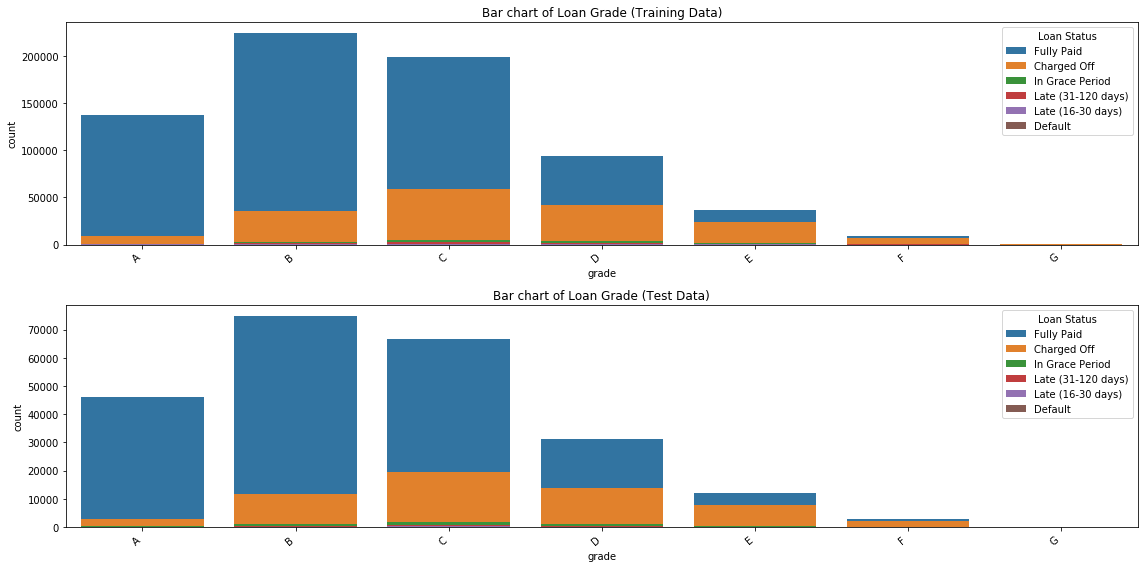

In [344]:
# Plot for Grade
f, ax = plt.subplots(2,1,figsize=(16,8))
labels = ['A','B','C','D','E','F','G']
labels_status=["Fully Paid", "Charged Off",  "In Grace Period", "Late (31-120 days)", "Late (16-30 days)", "Default"]

# Plot for Loan Grade - training data
sns.countplot(data = df_train, x='grade', hue='loan_status', order = labels, dodge=False ,ax=ax[0])
h,l = ax[0].get_legend_handles_labels()
ax[0].legend(h,labels_status,title="Loan Status", loc="upper right") 
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title("Bar chart of Loan Grade (Training Data)")

# Plot for Loan Grade - test data
sns.countplot(data = df_test, x='grade', hue='loan_status', order = labels, dodge=False ,ax=ax[1])
h,l = ax[1].get_legend_handles_labels()
ax[1].legend(h,labels_status,title="Loan Status", loc="upper right") 
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
ax[1].set_title("Bar chart of Loan Grade (Test Data)")

plt.tight_layout()
plt.show()

### Observation - Grade
* It would be common sense that the lower the grade the loan is, the higher the chance that it is a bad loan. This is indeed the case in above plot. 
* However, this raises the question whether _grade_ can be used a column for prediction, since this is the grade assigned by Lending Club itself, based on their prediction of the loan

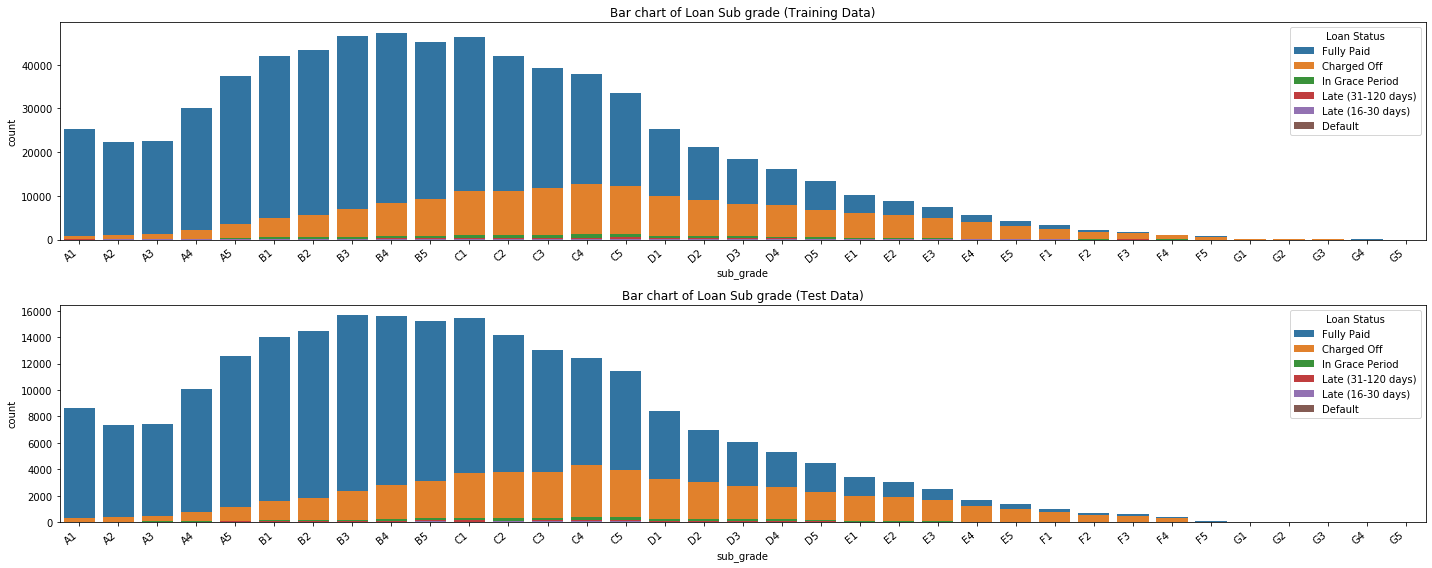

In [346]:
# Plot for Sub grade
f, ax = plt.subplots(2,1,figsize=(20,8))
labels = ['A1','A2','A3','A4','A5','B1','B2','B3','B4','B5','C1','C2','C3','C4','C5',\
          'D1','D2','D3','D4','D5','E1','E2','E3','E4','E5','F1','F2','F3','F4','F5','G1','G2','G3','G4','G5']
labels_status=["Fully Paid", "Charged Off",  "In Grace Period", "Late (31-120 days)", "Late (16-30 days)", "Default"]

# Plot for Loan Grade - training data
sns.countplot(data = df_train, x='sub_grade', hue='loan_status', order = labels, dodge=False ,ax=ax[0])
h,l = ax[0].get_legend_handles_labels()
ax[0].legend(h,labels_status,title="Loan Status", loc="upper right") 
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title("Bar chart of Loan Sub grade (Training Data)")

# Plot for Loan Grade - test data
sns.countplot(data = df_test, x='sub_grade', hue='loan_status', order = labels, dodge=False ,ax=ax[1])
h,l = ax[1].get_legend_handles_labels()
ax[1].legend(h,labels_status,title="Loan Status", loc="upper right") 
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
ax[1].set_title("Bar chart of Loan Sub grade (Test Data)")

plt.tight_layout()
plt.show()

### Observation - Sub Grade
* Similar to grade, we can see that the lower the sub-grade assigned by Lending Club, the higher the proportions of loans identified as bad loans. 
* We will think about whether to keep both Grade & Sub grade for prediction purpose.

## Bivariate/Multivariate Analysis
Next, we will perform some analysis between variables, to investigate their relationship, for further findings before prediction. The analysis will be done on both the training and the test dataset.

For example, in below analysis, we try to investigate relationship between __categorical variables__, such as _Loan Purpose, Employment Length, Loan Status_ and __continuous variable__ - _Loan Amount_

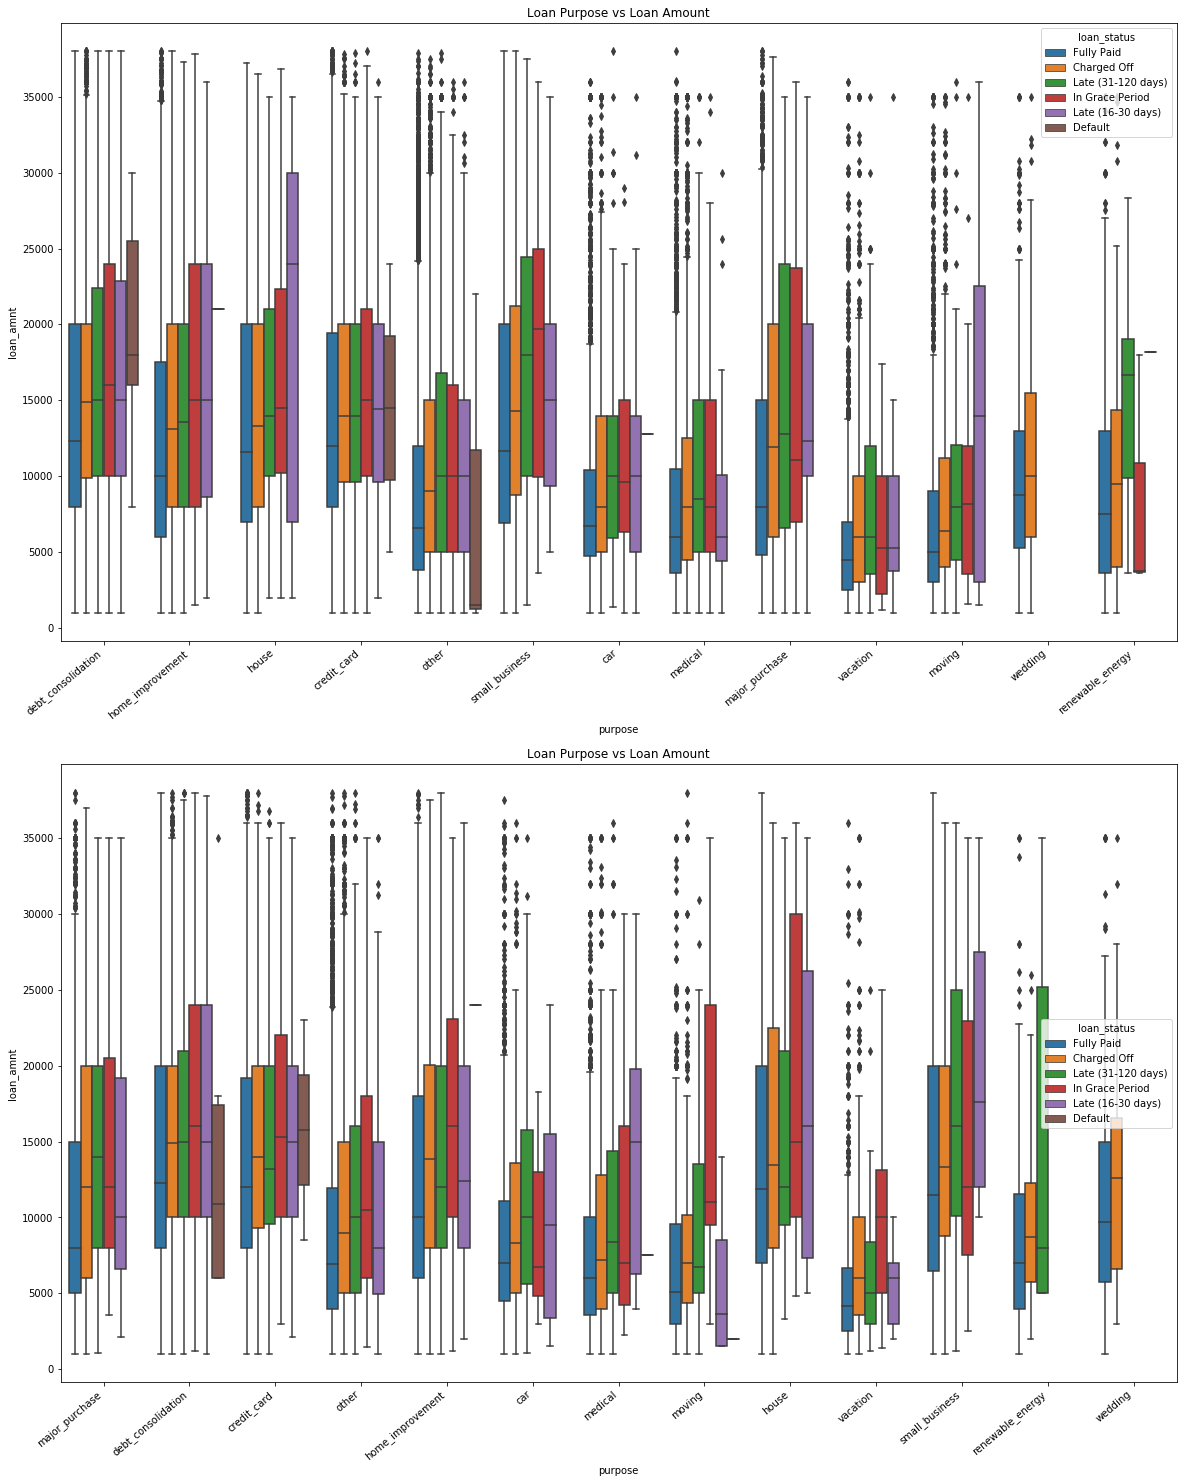

In [319]:
# Analysis and Purpose of the loan v.s. Loan amount
f, ax = plt.subplots(2,1,figsize=(20,25))

# Plot for training dataset
sns.boxplot(data=df_train, x='purpose', y='loan_amnt', hue ='loan_status',ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title('Loan Purpose vs Loan Amount')

# Plot for test dataset
sns.boxplot(data=df_test, x='purpose', y='loan_amnt', hue ='loan_status',ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
ax[1].set_title('Loan Purpose vs Loan Amount')
plt.show()

### Observation
* From above plot, we can see that some of the common purposes that give rise to high loan amount are: _debt_consolidation, house, and small_business_
* Most of the Loan defaults happens for loan purposes such as _credit_card, debt_consolidation & other_

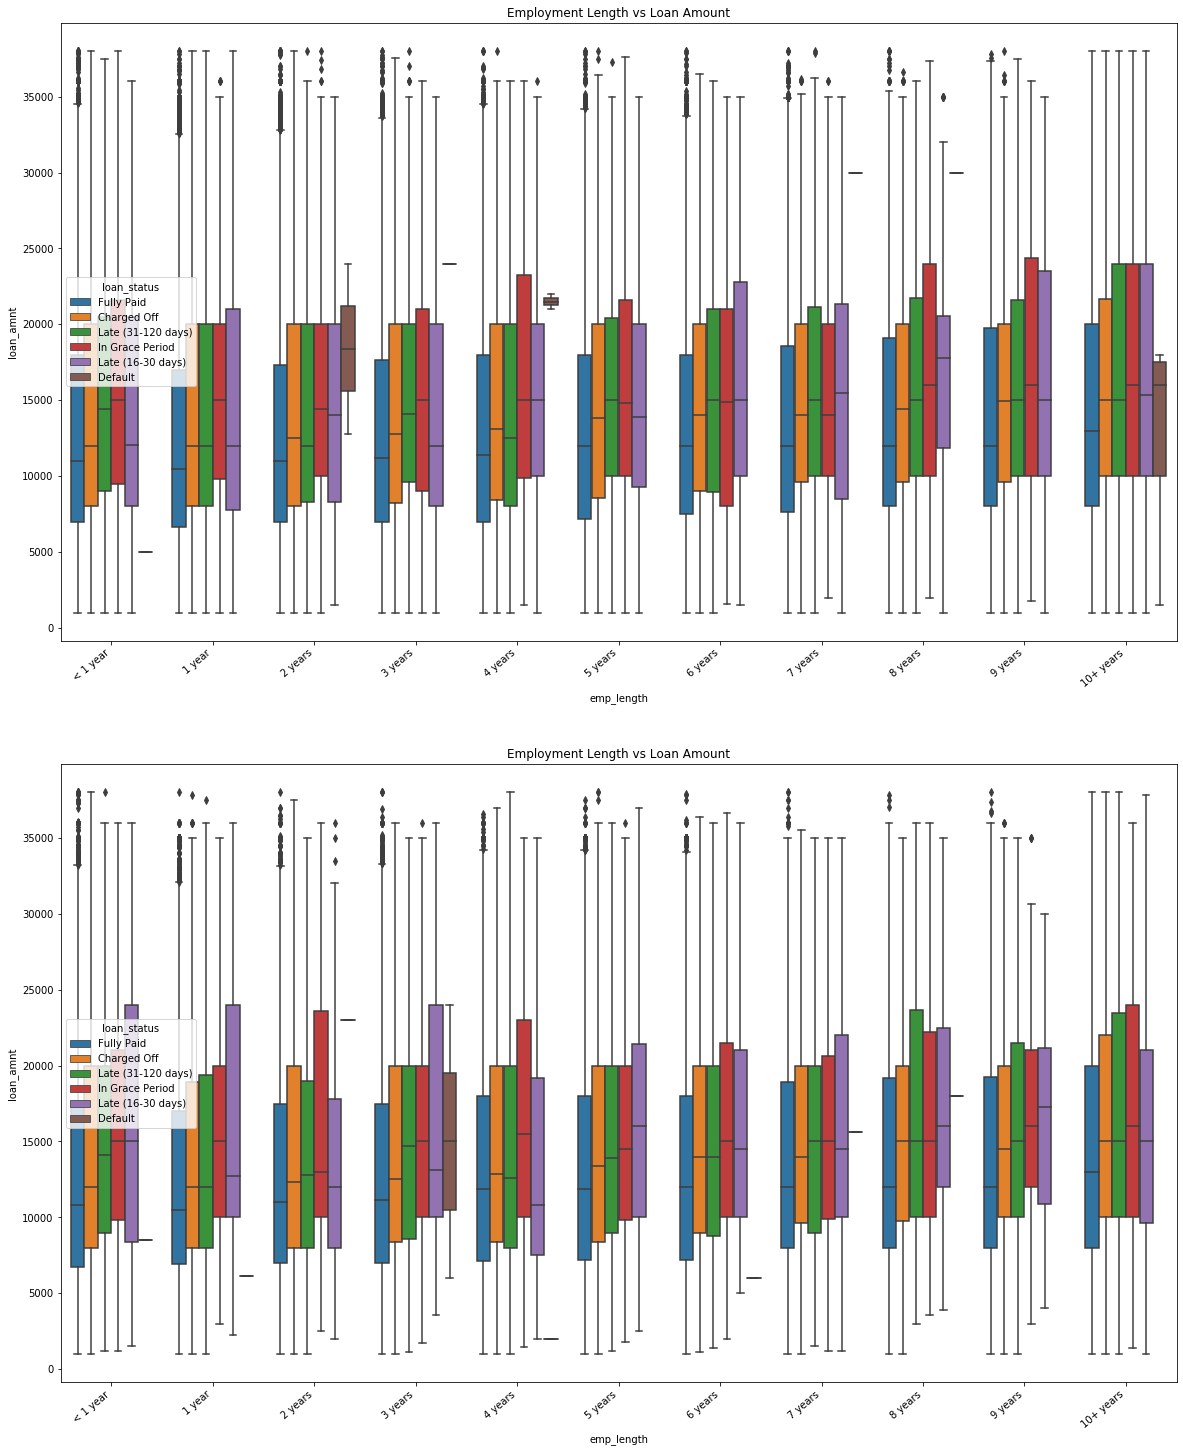

In [333]:
# Remove redundant emp_length_int column, created in section 1 for plotting graphs
df_train.drop(columns='emp_length_int',inplace=True)
df_test.drop(columns='emp_length_int',inplace=True)

# Analysis and Employment Length v.s. Loan amount
f, ax = plt.subplots(2,1,figsize=(20,25))
labels = ['< 1 year','1 year','2 years','3 years','4 years','5 years','6 years','7 years','8 years','9 years','10+ years']

# Plot for training dataset
sns.boxplot(data=df_train, x='emp_length', y='loan_amnt', order=labels, hue ='loan_status',ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title('Employment Length vs Loan Amount')

# Plot for test dataset
sns.boxplot(data=df_test, x='emp_length', y='loan_amnt', order=labels, hue ='loan_status',ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
ax[1].set_title('Employment Length vs Loan Amount')
plt.show()

### Observation
* We would have thought the lesser number of years employed, the more likely the borrower will apply for loans with larger amount. This is not necessarily the case except there are more outliers with exceptional large loan amounts.
* In terms of the risk, we can see that borrowers with less employment length are not necessarily mean more risks of the loan. We can see the proportion of loans fully paid to be about the same amongst various employment lengths.

Next, we try to investigate the __correlation between continuous variables__ in the dataset. If two or more variables are high correlated, we should just keep one of the variables during training and prediction

In [320]:
train_corr = df_train.corr()
train_corr

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,issue_y,issue_m,emp_length_int,loan_to_income_ratio
loan_amnt,1.000000,0.999986,0.999977,0.143692,0.951816,0.458674,0.052979,-0.006910,-0.023311,0.173720,...,-0.096671,-0.002575,0.298972,0.243196,0.347390,0.164524,-0.021844,-0.021587,0.090745,0.003804
funded_amnt,0.999986,1.000000,0.999992,0.143669,0.951829,0.458672,0.052980,-0.006906,-0.023318,0.173720,...,-0.096664,-0.002572,0.298972,0.243197,0.347400,0.164524,-0.021789,-0.021591,0.090740,0.003804
funded_amnt_inv,0.999977,0.999992,1.000000,0.143664,0.951788,0.458706,0.052932,-0.006911,-0.023304,0.173720,...,-0.096645,-0.002578,0.298993,0.243197,0.347424,0.164526,-0.021579,-0.021649,0.090745,0.003801
int_rate,0.143692,0.143669,0.143664,1.000000,0.147271,-0.115850,0.136862,0.044646,0.216794,-0.009504,...,0.051408,0.010721,-0.118427,0.015456,-0.237099,0.001742,-0.064936,0.003829,-0.006053,-0.000304
installment,0.951816,0.951829,0.951788,0.147271,1.000000,0.434049,0.055035,0.001797,-0.000595,0.161933,...,-0.089864,0.003350,0.259976,0.223583,0.313094,0.146758,-0.024471,-0.023687,0.077544,0.003774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
total_il_high_credit_limit,0.164524,0.164524,0.164526,0.001742,0.146758,0.334649,0.292942,0.062884,0.040200,0.358126,...,-0.028443,-0.000798,0.365543,0.896511,0.065049,1.000000,0.071718,-0.001974,-0.048796,-0.001423
issue_y,-0.021844,-0.021789,-0.021579,-0.064936,-0.024471,0.028241,0.044272,0.015559,-0.083776,0.021591,...,0.053822,0.020087,0.030061,0.047500,0.046098,0.071718,1.000000,-0.187337,-0.020608,0.001965
issue_m,-0.021587,-0.021591,-0.021649,0.003829,-0.023687,-0.009444,-0.002435,0.003595,-0.001524,-0.009695,...,-0.007049,-0.009006,-0.003451,-0.003622,-0.006160,-0.001974,-0.187337,1.000000,-0.003749,0.001143
emp_length_int,0.090745,0.090740,0.090745,-0.006053,0.077544,0.131809,0.022154,0.022059,0.001160,0.035832,...,0.027099,0.010443,0.131223,-0.029048,0.063083,-0.048796,-0.020608,-0.003749,1.000000,-0.001024


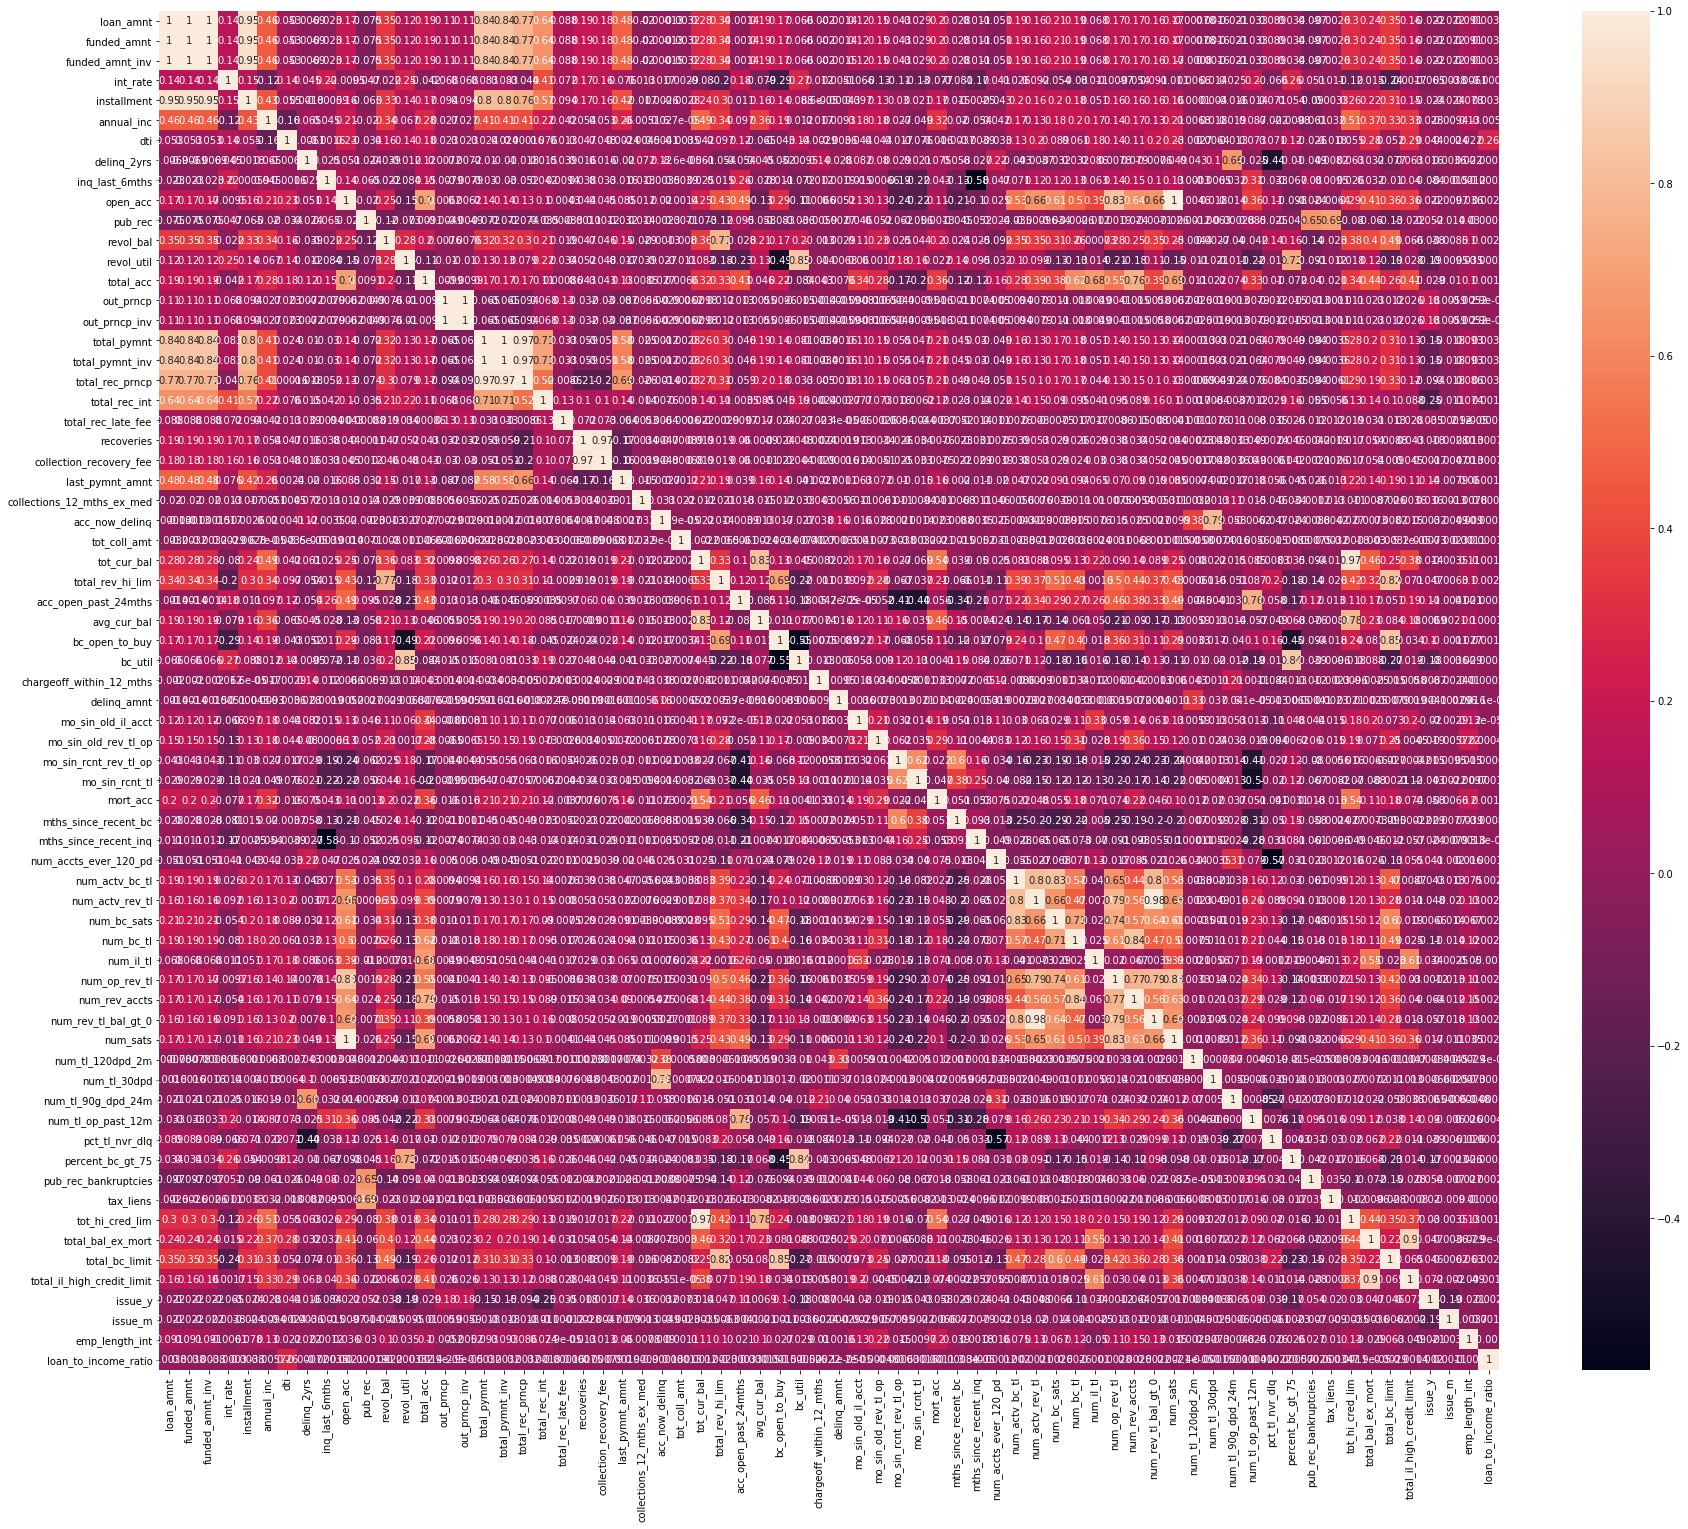

In [321]:
f, ax = plt.subplots(figsize=(30, 25))
sns.heatmap(train_corr, 
            xticklabels=train_corr.columns.values,
            yticklabels=train_corr.columns.values,annot= True)
plt.show()

### Observation
We inspect which columns have correlation score of 0.95 and above, and remove the redundant columns, for both training and test set.
* As we have previously suspected, _[loan_amnt, funded_amnt, funded_amnt_inv]_ are highly correlated. We can thus keep __loan_amnt__ only, for our prediction model
* Similarly, _[total_pymnt, total_pymnt, total_rec_int]_ are highly correlated, as all these indicate the total payment received to date. Hence, we can keep __total_pymnt__ column only. 
* _[num_sats, open_acc]_ are also perfectly correlated as both indicate the number of accounts already opened by the borrower. We can thus keep __open_acc__ only.
* _[tot_cur_bal, tot_hi_cred_lim]_ are highly correlated as both indicate the total credit limit / current balance of the borrower. We will keep __total_cur_bal__, for our prediction purpose
* _[num_actv_rev_tl, num_rev_tl_bal_gt_0]_ are both linked to the number of revolving trade, and highly correlated. We will ony keep __num_actv_rev_tl__ in this case.

In [329]:
redundant_cols = ['funded_amnt', 'funded_amnt_inv', 'total_pymnt', \
                  'total_rec_int', 'num_sats', 'tot_hi_cred_lim','num_rev_tl_bal_gt_0']
df_train.drop(columns=redundant_cols, inplace=True)
df_test.drop(columns=redundant_cols, inplace=True)

print (df_train.shape)
print (df_test.shape)

(900078, 86)
(299189, 86)


In [347]:
df_train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900078 entries, 1832470 to 868271
Data columns (total 84 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   loan_amnt                   900078 non-null  int64   
 1   term                        900078 non-null  object  
 2   int_rate                    900078 non-null  float64 
 3   installment                 900078 non-null  float64 
 4   grade                       900078 non-null  object  
 5   sub_grade                   900078 non-null  object  
 6   emp_title                   840272 non-null  object  
 7   emp_length                  843965 non-null  object  
 8   home_ownership              900078 non-null  object  
 9   annual_inc                  900078 non-null  float64 
 10  verification_status         900078 non-null  object  
 11  issue_d                     900078 non-null  object  
 12  loan_status                 900078 non-null  object 

(900078, 63)
